In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Read images

In [3]:
train_imgs = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [4]:
train_imgs.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see that the training labels are in the first column, and all other columns contain the pixel value of a particular 28x28 image

In [5]:
train_data, train_label = train_imgs.drop(['label'], axis=1), train_imgs['label']


Visualise the first 10 images in the train dataset

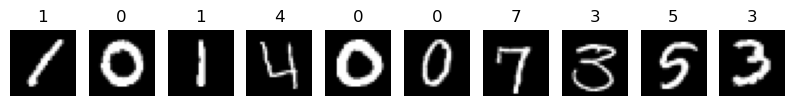

In [6]:
fig, ax = plt.subplots(ncols=10, figsize=(10, 50))
for i in range(10):
        ax[i].imshow(train_data.iloc[i].to_numpy().reshape(28, 28), cmap='gray')
        ax[i].set_title(train_label[i])
        ax[i].axis('off')

# Preprocessing
- apply Otsu's thresholding to convert grayscale image to binary image
- apply morphological opening to smoothen contours

In [7]:
def threshold_row_img(row):
    img = row.to_numpy().reshape(28, 28).astype(np.uint8)
    _, otsu_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return otsu_img

def preprocess_df(df):
    res = []
    for i in range(df.shape[0]):
        thresholded_img = threshold_row_img(df.iloc[i])
        # apply opening to smoothen contours
        thresholded_img = cv2.erode(thresholded_img, np.ones((2, 2), np.uint8), iterations=1)
        thresholded_img = cv2.dilate(thresholded_img, np.ones((2, 2), np.uint8), iterations=1)
        res.append(thresholded_img.flatten())
    return np.array(res)

In [8]:
preprocessed_train_data = preprocess_df(train_data)

In [9]:
preprocessed_train_data.shape

(42000, 784)

In [10]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)
ohe_train_labels = enc.fit_transform(train_label.to_numpy().reshape(-1, 1))


In [11]:
ohe_train_labels.shape

(42000, 10)

Next, we split the training images using an 80:20 split

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_train_data, ohe_train_labels, test_size=0.2, random_state=28)

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33600, 784) (8400, 784) (33600, 10) (8400, 10)


# Train model

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, input_shape=(784,), activation='sigmoid'),
    tf.keras.layers.Dense(10)
])

In [15]:
# apply early stopping to training
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/300
840/840 [==============================] - 5s 5ms/step - loss: 0.8184 - accuracy: 0.7724 - val_loss: 0.5453 - val_accuracy: 0.8519
Epoch 2/300
840/840 [==============================] - 4s 5ms/step - loss: 0.4993 - accuracy: 0.8554 - val_loss: 0.4790 - val_accuracy: 0.8626
Epoch 3/300
840/840 [==============================] - 4s 5ms/step - loss: 0.4553 - accuracy: 0.8643 - val_loss: 0.4241 - val_accuracy: 0.8754
Epoch 4/300
840/840 [==============================] - 4s 4ms/step - loss: 0.4155 - accuracy: 0.8757 - val_loss: 0.4071 - val_accuracy: 0.8757
Epoch 5/300
840/840 [==============================] - 4s 5ms/step - loss: 0.3974 - accuracy: 0.8807 - val_loss: 0.3957 - val_accuracy: 0.8811
Epoch 6/300
840/840 [==============================] - 4s 4ms/step - loss: 0.3800 - accuracy: 0.8872 - val_loss: 0.3818 - val_accuracy: 0.8815
Epoch 7/300
840/840 [==============================] - 4s 5ms/step - loss: 0.3747 - accuracy: 0.8862 - val_loss: 0.4006 - val_accuracy: 0.8784

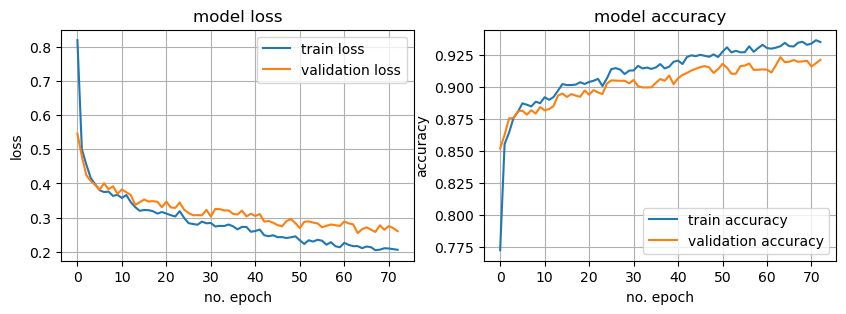

In [17]:
# plot accuracy and loss curves
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

ax[0].plot(history.history['loss'], label='train loss')
ax[0].plot(history.history['val_loss'], label='validation loss')
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('no. epoch')
ax[0].legend()
ax[0].grid()

ax[1].plot(history.history['accuracy'], label='train accuracy')
ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('no. epoch')
ax[1].legend()
ax[1].grid()
plt.show()

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.2%}, Test Loss={test_loss:.4f}')

263/263 - 1s - loss: 0.2688 - accuracy: 0.9183 - 592ms/epoch - 2ms/step
Test accuracy: 91.83%, Test Loss=0.2688


# Make predictions on test images

In [19]:
# read testimages
test_imgs = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
print(test_imgs.shape)

(28000, 784)


In [20]:
# preprocess test images
preprocessed_test_data = preprocess_df(test_imgs)

In [21]:
# make predictions using model
scores = model.predict(preprocessed_test_data)
preds = np.argmax(scores, axis=1) # the class with the highest score is selected as the predicted class

875/875 [==============================] - 2s 2ms/step


In [22]:
# create results dataframe
res_df = pd.DataFrame({'ImageId':list(range(1, 28001)), 'Label':preds})
res_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3


In [23]:
# write results to a csv file for submission
res_df.to_csv('submission.csv', index=False)